## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!pip install wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

/bin/sh: 1: wget: not found


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
file = 'data/data_000637.txt'

In [3]:
import numpy.random as npr
#1. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.
N = npr.randint(10000,1310720) 
df = pd.read_csv(file, nrows = N)

In [4]:
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
194893,1,1,10,3869202106,374,24
194894,1,0,27,3869202106,375,11
194895,1,0,54,3869202106,367,17
194896,1,0,56,3869202106,365,7


In [5]:
# 2. Find out the number of BX in a ORBIT (the value 'x').
# The number of Bx in an orbit is bounded by the maximum observed value in Bx_counter + 1.
# Given the sample size, we'll assume this lower bound to be precisely the value we are looking for.
T_x = df['BX_COUNTER'].max()+1
print(f'The number bx in an orbit is {T_x}')

The number bx in an orbit is 3564


In [6]:
# 3. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.
total_orbs = df['ORBIT_CNT'].max()-df['ORBIT_CNT'].min()
total_ms = total_orbs*T_x*25e-6
print(f'Total sampled time is approximately {round(total_ms,2)} milliseconds')

Total sampled time is approximately 172.76 milliseconds


In [7]:
# 4. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).
df['ABS_TIME'] = df['ORBIT_CNT']*T_x*25e-9+df['BX_COUNTER']*25e-9+df['TDC_MEAS']*(25/30)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,344767.401606
1,1,0,124,3869200167,2374,27,344768.234939
2,1,0,63,3869200167,2553,28,344769.068277
3,1,0,64,3869200167,2558,19,344761.568277
4,1,0,64,3869200167,2760,25,344766.568282
...,...,...,...,...,...,...,...
194893,1,1,10,3869202106,374,24,344765.907654
194894,1,0,27,3869202106,375,11,344755.074321
194895,1,0,54,3869202106,367,17,344760.074320
194896,1,0,56,3869202106,365,7,344751.740987


In [8]:
#5. Replace the values (all 1) of the HEAD column randomly with 0 or 1.
df['HEAD'] = npr.randint(0,2,len(df))
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,0,0,123,3869200167,2374,26,344767.401606
1,1,0,124,3869200167,2374,27,344768.234939
2,0,0,63,3869200167,2553,28,344769.068277
3,1,0,64,3869200167,2558,19,344761.568277
4,0,0,64,3869200167,2760,25,344766.568282
...,...,...,...,...,...,...,...
194893,1,1,10,3869202106,374,24,344765.907654
194894,0,0,27,3869202106,375,11,344755.074321
194895,1,0,54,3869202106,367,17,344760.074320
194896,1,0,56,3869202106,365,7,344751.740987


In [9]:
# 6. Create a new DataFrame that contains only the rows with HEAD=1.
fdf = df[df['HEAD']==1]
fdf

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
1,1,0,124,3869200167,2374,27,344768.234939
3,1,0,64,3869200167,2558,19,344761.568277
5,1,0,63,3869200167,2762,4,344749.068282
6,1,0,61,3869200167,2772,14,344757.401616
12,1,1,6,3869200167,2792,18,344760.734950
...,...,...,...,...,...,...,...
194892,1,0,63,3869202106,364,12,344755.907654
194893,1,1,10,3869202106,374,24,344765.907654
194895,1,0,54,3869202106,367,17,344760.074320
194896,1,0,56,3869202106,365,7,344751.740987


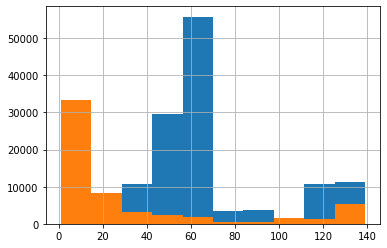

In [32]:
# 7. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel
for fpga in df['FPGA'].unique():
    hjik = df[df['FPGA']==fpga]['TDC_CHANNEL'].hist()

In [31]:
# 8. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)
h = df.groupby('TDC_CHANNEL')
noisy = h.size().sort_values(ascending = False)
noisy[:3]

TDC_CHANNEL
139    16206
64      9642
63      9425
dtype: int64

In [12]:
# 9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
counts = df['ORBIT_CNT'].size
print(f'There are {counts} unique orbits.')
# We extract those unique orbits with at least one measurement from channel 139
orbits = df[df['TDC_CHANNEL'] == 139]['ORBIT_CNT'].unique().size
print(f'There are {orbits} unique orbits with at least one measurement from channel 139')

There are 194898 unique orbits.
There are 1936 unique orbits with at least one measurement from channel 139


pandas.core.series.Series